In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv("shot_logs.csv")
display(data.shape)
display(data.head())

(128069, 21)

,GAME_ID,MATCHUP,LOCATION,W,FINAL_MARGIN,SHOT_NUMBER,PERIOD,GAME_CLOCK,SHOT_CLOCK,DRIBBLES,...,SHOT_DIST,PTS_TYPE,SHOT_RESULT,CLOSEST_DEFENDER,CLOSEST_DEFENDER_PLAYER_ID,CLOSE_DEF_DIST,FGM,PTS,player_name,player_id
0,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,1,1,1:09,10.8,2,...,7.7,2,made,"Anderson, Alan",101187,1.3,1,2,brian roberts,203148
1,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,2,1,0:14,3.4,0,...,28.2,3,missed,"Bogdanovic, Bojan",202711,6.1,0,0,brian roberts,203148
2,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,3,1,0:00,NaN,3,...,10.1,2,missed,"Bogdanovic, Bojan",202711,0.9,0,0,brian roberts,203148
3,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,4,2,11:47,10.3,2,...,17.2,2,missed,"Brown, Markel",203900,3.4,0,0,brian roberts,203148
4,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,5,2,10:34,10.9,2,...,3.7,2,missed,"Young, Thaddeus",201152,1.1,0,0,brian roberts,203148


Možemo vidjeti kako se dataset sastoji od 128069 zapisa te 21 značajke.

Za početak ćemo pronaći sve nedostajuće vrijednosti.

In [3]:
display(data.isna().sum())

GAME_ID                          0
MATCHUP                          0
LOCATION                         0
W                                0
FINAL_MARGIN                     0
SHOT_NUMBER                      0
PERIOD                           0
GAME_CLOCK                       0
SHOT_CLOCK                    5567
DRIBBLES                         0
TOUCH_TIME                       0
SHOT_DIST                        0
PTS_TYPE                         0
SHOT_RESULT                      0
CLOSEST_DEFENDER                 0
CLOSEST_DEFENDER_PLAYER_ID       0
CLOSE_DEF_DIST                   0
FGM                              0
PTS                              0
player_name                      0
player_id                        0
dtype: int64

Vidimo kako nedostaje 5567 podataka u SHOT_CLOCK stupcu. Najbolja opcija je izbacivanje ovih zapisa iz skupa podataka, pošto ne čine značajan udio u cjelokupnome datasetu, a ova značajka bi nam potencijalno mogla biti vrlo važna.

In [4]:
data = data[data.SHOT_CLOCK.notnull()]
display(data.isna().sum())

GAME_ID                       0
MATCHUP                       0
LOCATION                      0
W                             0
FINAL_MARGIN                  0
SHOT_NUMBER                   0
PERIOD                        0
GAME_CLOCK                    0
SHOT_CLOCK                    0
DRIBBLES                      0
TOUCH_TIME                    0
SHOT_DIST                     0
PTS_TYPE                      0
SHOT_RESULT                   0
CLOSEST_DEFENDER              0
CLOSEST_DEFENDER_PLAYER_ID    0
CLOSE_DEF_DIST                0
FGM                           0
PTS                           0
player_name                   0
player_id                     0
dtype: int64

In [5]:
data.nunique()

GAME_ID                        896
MATCHUP                       1792
LOCATION                         2
W                                2
FINAL_MARGIN                    88
SHOT_NUMBER                     37
PERIOD                           7
GAME_CLOCK                     718
SHOT_CLOCK                     241
DRIBBLES                        33
TOUCH_TIME                     309
SHOT_DIST                      368
PTS_TYPE                         2
SHOT_RESULT                      2
CLOSEST_DEFENDER               473
CLOSEST_DEFENDER_PLAYER_ID     474
CLOSE_DEF_DIST                 297
FGM                              2
PTS                              3
player_name                    281
player_id                      281
dtype: int64

Uvidom u ovu tablicu te isječak datseta možemo zaključiti kako nema monotonih i konstantnih vrijednosti. Za stršeće vrijednosti najbolje je provjeriti korištenjem z-vrijednosti značajki:

In [6]:
from scipy import stats

columns_to_check = data.select_dtypes(include=['number']).columns.tolist()

print("Najviše stršeće vrijednosti značajki:")
print()

for col in columns_to_check:
    z_scores = stats.zscore(data[col])
    outliers = data[abs(z_scores) > 3]

    if not outliers.empty:
        abs_z_scores = abs(z_scores[outliers.index])
        outliers_sorted = outliers.iloc[abs_z_scores.argsort()[::-1]]
        print(outliers_sorted[[col]].head(), '\n')


Najviše stršeće vrijednosti značajki:

       FINAL_MARGIN
73590           -53
73837           -53
73252           -53
73253           -53
73254           -53 

        SHOT_NUMBER
104772           37
104771           36
10436            36
44908            36
10435            35 

        PERIOD
127995       7
116344       7
82519        7
81576        7
79452        7 

        DRIBBLES
121565        32
77107         31
108507        31
125774        31
76842         30 

       TOUCH_TIME
5574       -100.5
87255        24.9
34112        24.5
94204        24.4
54283        23.9 

        SHOT_DIST
77416        43.5
45150        43.3
37521        42.8
105565       42.2
107097       41.5 

       CLOSEST_DEFENDER_PLAYER_ID
89953                      530027
89952                      530027
71297                      530027
71292                      530027
39495                      530027 

       CLOSE_DEF_DIST
46520            53.2
82616            52.9
89106            52.6
4877   

Iz ovih vrijednosti te uvidom u sami dataset možemo zaključiti da se jedina prava stršeća vrijednost nalazi u stupcu TOUCH_TIME te ćemo ta taj redak ukloniti iz dataseta. Sve ostale vrijednosti koje su "uhvaćene" korištenjem z-vrijednosti su relevantne za naš dataset te ne odskaču previše. 

In [7]:
data = data.drop(data[data["TOUCH_TIME"] == -100.5].index)

U nastavku ćemo proučiti statistike značajki. Za numeričke značajke ispisat ćemo uobičajene mjere, a za kategoričke ćemo ispisati učestalost pojavljivanja pojedine vrijednosti (samo prvih 5 jer ih ima previše za pojedine značajke).

In [8]:
display(data.describe())
for col in data.select_dtypes(include=['object']).columns:
    display(pd.DataFrame(data[col].value_counts()).head())
    print()

,GAME_ID,FINAL_MARGIN,SHOT_NUMBER,PERIOD,SHOT_CLOCK,DRIBBLES,TOUCH_TIME,SHOT_DIST,PTS_TYPE,CLOSEST_DEFENDER_PLAYER_ID,CLOSE_DEF_DIST,FGM,PTS,player_id
count,1.225010e+05,122501.000000,122501.000000,122501.000000,122501.000000,122501.000000,122501.000000,122501.000000,122501.000000,122501.000000,122501.000000,122501.000000,122501.000000,122501.000000
mean,2.140045e+07,0.252382,6.476192,2.471457,12.453323,1.989249,2.749045,13.443657,2.258365,159120.062040,4.121714,0.456160,1.005478,157334.545547
std,2.578233e+02,13.311471,4.681254,1.137902,5.763284,3.411197,2.942498,8.777078,0.437738,78689.894847,2.751597,0.498076,1.131130,79305.173131
min,2.140000e+07,-53.000000,1.000000,1.000000,0.000000,0.000000,-14.000000,0.000000,2.000000,708.000000,0.000000,0.000000,0.000000,708.000000
25%,2.140023e+07,-8.000000,3.000000,1.000000,8.200000,0.000000,0.900000,4.700000,2.000000,200745.000000,2.300000,0.000000,0.000000,101162.000000
50%,2.140045e+07,1.000000,5.000000,2.000000,12.300000,1.000000,1.600000,13.400000,2.000000,201949.000000,3.700000,0.000000,0.000000,201939.000000
75%,2.140067e+07,9.000000,9.000000,3.000000,16.700000,2.000000,3.700000,22.400000,3.000000,203079.000000,5.300000,1.000000,2.000000,202704.000000
max,2.140091e+07,53.000000,37.000000,7.000000,24.000000,32.000000,24.900000,43.500000,3.000000,530027.000000,53.200000,1.000000,3.000000,204060.000000


,count
MATCHUP,
"FEB 07, 2015 - DAL vs. POR",102
"NOV 30, 2014 - TOR @ LAL",99
"DEC 04, 2014 - GSW vs. NOP",97
"JAN 29, 2015 - CHI @ LAL",97
"JAN 21, 2015 - WAS vs. OKC",96


,count
LOCATION,
A,61314
H,61187


,count
W,
W,62148
L,60353


,count
GAME_CLOCK,
11:46,265
0:34,262
0:32,262
11:45,251
0:33,246


,count
SHOT_RESULT,
missed,66621
made,55880


,count
CLOSEST_DEFENDER,
"Ibaka, Serge",802
"Jordan, DeAndre",786
"Green, Draymond",737
"Gasol, Pau",716
"Millsap, Paul",702


,count
player_name,
lamarcus aldridge,1010
james harden,1006
mnta ellis,1004
klay thompson,953
lebron james,947


Sada ćemo normalizirati numeričke značajke. Vidimo da je GAME_CLOCK u minutama te ćemo to prvo pretvoriti u sekunde, tj. to će sada biti numerički podatak.

In [9]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

data["GAME_CLOCK"] = pd.to_timedelta("00:" + data["GAME_CLOCK"]).dt.total_seconds()

numerical = data.select_dtypes(include=['number']).columns

data2 = data.copy()
data2[numerical] = scaler.fit_transform(data2[numerical])
data2.head()

,GAME_ID,MATCHUP,LOCATION,W,FINAL_MARGIN,SHOT_NUMBER,PERIOD,GAME_CLOCK,SHOT_CLOCK,DRIBBLES,...,SHOT_DIST,PTS_TYPE,SHOT_RESULT,CLOSEST_DEFENDER,CLOSEST_DEFENDER_PLAYER_ID,CLOSE_DEF_DIST,FGM,PTS,player_name,player_id
0,1.733566,"MAR 04, 2015 - CHA @ BKN",A,W,1.784004,-1.169818,-1.293138,-1.445711,-0.286873,0.003152,...,-0.654395,-0.590231,made,"Anderson, Alan",-0.736223,-1.025487,1.091886,0.879233,brian roberts,0.577688
1,1.733566,"MAR 04, 2015 - CHA @ BKN",A,W,1.784004,-0.956199,-1.293138,-1.717958,-1.570868,-0.583155,...,1.681243,1.694252,missed,"Bogdanovic, Bojan",0.553961,0.718962,-0.915846,-0.888918,brian roberts,0.577688
3,1.733566,"MAR 04, 2015 - CHA @ BKN",A,W,1.784004,-0.528961,-0.414323,1.712356,-0.373629,0.003152,...,0.427974,-0.590231,missed,"Brown, Markel",0.569071,-0.262290,-0.915846,-0.888918,brian roberts,0.577688
4,1.733566,"MAR 04, 2015 - CHA @ BKN",A,W,1.784004,-0.315342,-0.414323,1.351010,-0.269522,0.003152,...,-1.110130,-0.590231,missed,"Young, Thaddeus",0.534149,-1.098172,-0.915846,-0.888918,brian roberts,0.577688
5,1.733566,"MAR 04, 2015 - CHA @ BKN",A,W,1.784004,-0.101724,-0.414323,0.662967,-0.581845,0.003152,...,0.564694,-0.590231,missed,"Williams, Deron",-0.737151,-0.553032,-0.915846,-0.888918,brian roberts,0.577688


In [10]:
data2.dtypes

GAME_ID                       float64
MATCHUP                        object
LOCATION                       object
W                              object
FINAL_MARGIN                  float64
SHOT_NUMBER                   float64
PERIOD                        float64
GAME_CLOCK                    float64
SHOT_CLOCK                    float64
DRIBBLES                      float64
TOUCH_TIME                    float64
SHOT_DIST                     float64
PTS_TYPE                      float64
SHOT_RESULT                    object
CLOSEST_DEFENDER               object
CLOSEST_DEFENDER_PLAYER_ID    float64
CLOSE_DEF_DIST                float64
FGM                           float64
PTS                           float64
player_name                    object
player_id                     float64
dtype: object

Možemo vidjeti kako je većina značajki numerička, uz nekoliko kategoričkih značajki, poput MATCHUP, LOCATION itd. Kategoričke varijable pretvorit ćemo u numeričke. Također, izbacit ćemo CLOSEST_DEFENDER značajku jer je nepotrebna, pošto CLOSEST_DEFENDER_PLAYER_ID predstavlja tu značajku u numeričkome obliku. 

In [11]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

data3 = data2.copy()

data3["MATCHUP"] = le.fit_transform(data3["MATCHUP"]).astype('int64')
data3["LOCATION"] = le.fit_transform(data3["LOCATION"]).astype('int64')
data3["W"] = le.fit_transform(data3["W"]).astype('int64')
data3["SHOT_RESULT"] = le.fit_transform(data3["SHOT_RESULT"]).astype('int64')
data3["player_name"] = le.fit_transform(data3["player_name"]).astype('int64')

data3.drop(("CLOSEST_DEFENDER"), axis=1, inplace=True)
display(data3.dtypes)
data3.head()

GAME_ID                       float64
MATCHUP                         int64
LOCATION                        int64
W                               int64
FINAL_MARGIN                  float64
SHOT_NUMBER                   float64
PERIOD                        float64
GAME_CLOCK                    float64
SHOT_CLOCK                    float64
DRIBBLES                      float64
TOUCH_TIME                    float64
SHOT_DIST                     float64
PTS_TYPE                      float64
SHOT_RESULT                     int64
CLOSEST_DEFENDER_PLAYER_ID    float64
CLOSE_DEF_DIST                float64
FGM                           float64
PTS                           float64
player_name                     int64
player_id                     float64
dtype: object

,GAME_ID,MATCHUP,LOCATION,W,FINAL_MARGIN,SHOT_NUMBER,PERIOD,GAME_CLOCK,SHOT_CLOCK,DRIBBLES,TOUCH_TIME,SHOT_DIST,PTS_TYPE,SHOT_RESULT,CLOSEST_DEFENDER_PLAYER_ID,CLOSE_DEF_DIST,FGM,PTS,player_name,player_id
0,1.733566,1282,0,1,1.784004,-1.169818,-1.293138,-1.445711,-0.286873,0.003152,-0.288547,-0.654395,-0.590231,0,-0.736223,-1.025487,1.091886,0.879233,35,0.577688
1,1.733566,1282,0,1,1.784004,-0.956199,-1.293138,-1.717958,-1.570868,-0.583155,-0.662380,1.681243,1.694252,1,0.553961,0.718962,-0.915846,-0.888918,35,0.577688
3,1.733566,1282,0,1,1.784004,-0.528961,-0.414323,1.712356,-0.373629,0.003152,-0.288547,0.427974,-0.590231,1,0.569071,-0.262290,-0.915846,-0.888918,35,0.577688
4,1.733566,1282,0,1,1.784004,-0.315342,-0.414323,1.351010,-0.269522,0.003152,-0.016668,-1.110130,-0.590231,1,0.534149,-1.098172,-0.915846,-0.888918,35,0.577688
5,1.733566,1282,0,1,1.784004,-0.101724,-0.414323,0.662967,-0.581845,0.003152,0.561075,0.564694,-0.590231,1,-0.737151,-0.553032,-0.915846,-0.888918,35,0.577688


Sada ćemo vizualizirati podatke na nekoliko različitih načina.

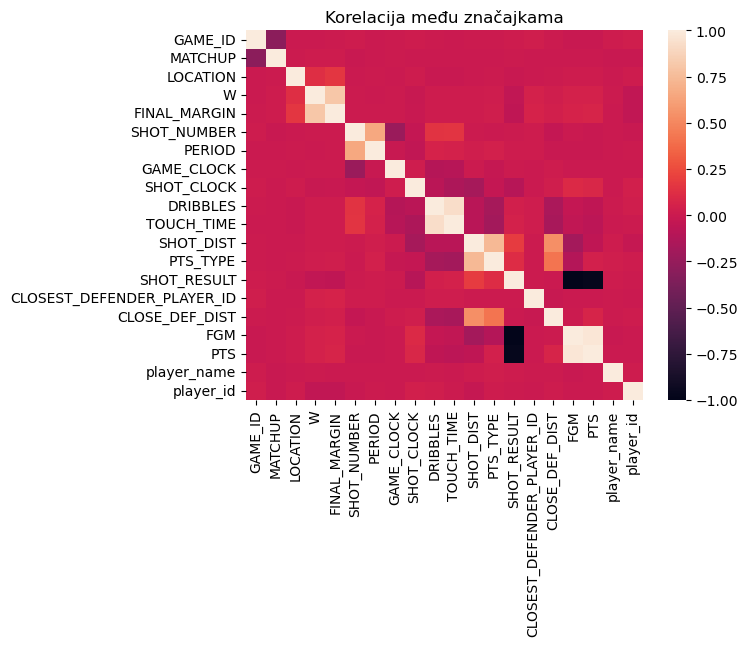

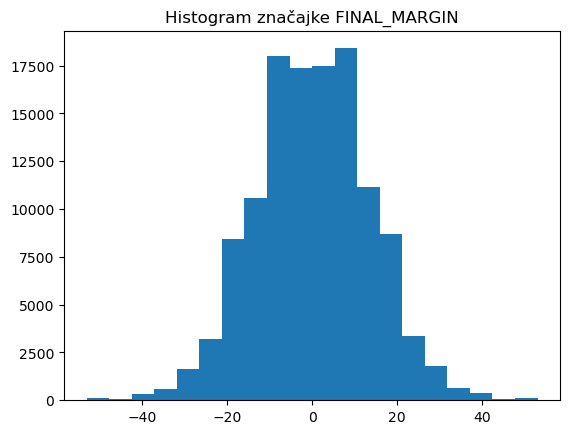

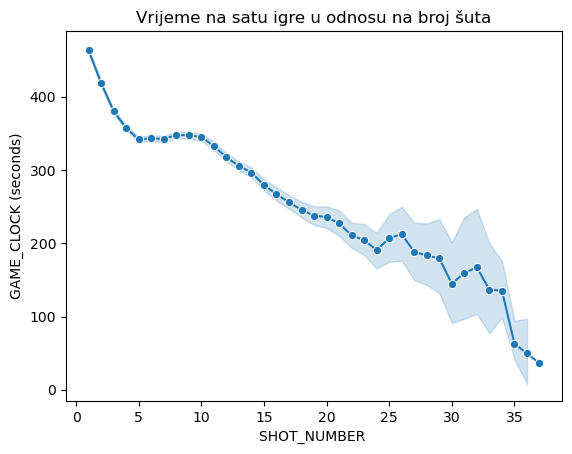

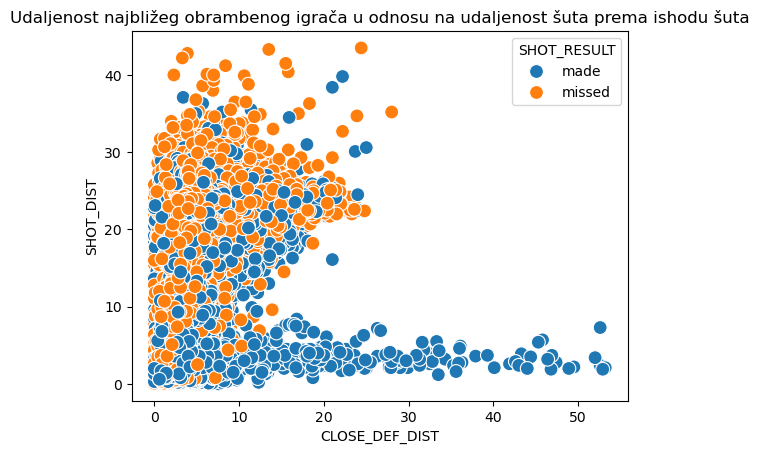

In [12]:
sns.heatmap(data3.corr())
plt.title("Korelacija među značajkama")
plt.show()

plt.hist(data.FINAL_MARGIN, bins=20)
plt.title("Histogram značajke FINAL_MARGIN")
plt.show()

sns.lineplot(x='SHOT_NUMBER', y='GAME_CLOCK', data=data, marker='o')
plt.title("Vrijeme na satu igre u odnosu na broj šuta")
plt.xlabel("SHOT_NUMBER ")
plt.ylabel("GAME_CLOCK (seconds)")
plt.show()

sns.scatterplot(x='CLOSE_DEF_DIST', y='SHOT_DIST', hue='SHOT_RESULT', data=data, s=100)
plt.title("Udaljenost najbližeg obrambenog igrača u odnosu na udaljenost šuta prema ishodu šuta")
plt.xlabel("CLOSE_DEF_DIST")
plt.ylabel("SHOT_DIST")
plt.show()